In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *
print(torch.cuda.is_available())

False


### Bivariate Normal Data Generation

In [101]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 5],
    2: [3, 1],
    3: [1.5, 6],
    4: [6, 1]
}
std = 0.3
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2,
    4: np.eye(2)*std**2
}
K = 5
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3, 4]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

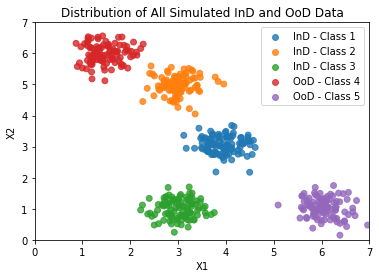

In [107]:
for idx in IND_CLS:
    sample_idx = np.random.choice(1000, 100, replace=False)
    plt.scatter(IND_X[:,0][IND_Y==idx][sample_idx], IND_X[:,1][IND_Y==idx][sample_idx], label =f"InD - Class {idx+1}", sizes=[35]*len(IND_X),alpha=0.8)
sample_idx = np.random.choice(1000, 100, replace=False)
for idx in OOD_CLS:
    sample_idx = np.random.choice(1000, 100, replace=False)
    plt.scatter(OOD_X[:,0][OOD_Y==idx][sample_idx], OOD_X[:,1][OOD_Y==idx][sample_idx], label =f"OoD - Class {idx + 1}", sizes=[35]*len(OOD_X), alpha=0.8)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Distribution of All Simulated InD and OoD Data")
# plt.show()
plt.savefig(f"simulation_log/plot/example_distribution.jpg", dpi=1500)

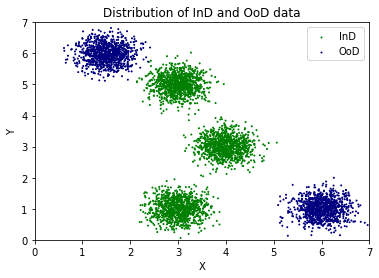

In [108]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [ ]:
from tqdm import tqdm
from simulation import classifier_training, DSIM_SINGLE, GSIM_SINGLE
D = DSIM(128)
# D = DSIM_SINGLE()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

### WOOD Training

In [125]:
# Load checkpoint (if necessary)
name = 'eg-[n=2]/ckpt'
D = torch.load(f"simulation_log/example/{name}/D.pt")
OOD_BATCH = torch.load(f"simulation_log/example/{name}/OOD_BATCH.pt")
OOD_X = torch.load(f"simulation_log/example/{name}/OOD_X.pt")
OOD_X_TEST = torch.load(f"simulation_log/example/{name}/OOD_X_TEST.pt")
IND_X = torch.load(f"simulation_log/example/{name}/IND_X.pt")
IND_X_TEST = torch.load(f"simulation_log/example/{name}/IND_X_TEST.pt")
IND_Y = torch.load(f"simulation_log/example/{name}/IND_Y.pt")
IND_Y_TEST = torch.load(f"simulation_log/example/{name}/IND_Y_TEST.pt")
SAMPLERS = torch.load(f'simulation_log/example/{name}/samplers.pt')
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = torch.load(f'simulation_log/example/{name}/raw_data.pt')
ind_idx, ood_idx = torch.load(f'simulation_log/example/{name}/plot_idx.pt')
IND_CLS = [0, 1, 2]
OOD_CLS = [3]

#### Check sampled points

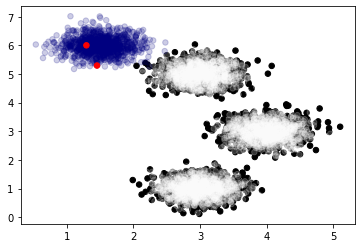

In [126]:
n_ood = 2
ood_bsz = 4
ckpt = True
if not ckpt:
    OOD_BATCH = []
    for idx in OOD_CLS:
        cls_batch = list(OOD_X[OOD_Y == idx][np.random.choice(n, n_ood, replace=False)]) 
        OOD_BATCH = OOD_BATCH + cls_batch
    OOD_BATCH = torch.tensor(OOD_BATCH, dtype=torch.float32)

    torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
plt.scatter(IND_X[:,0], IND_X[:,1], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='red', label="OoD", sizes=[30]*len(OOD_X), alpha=1)


#### Training

In [ ]:
from simulation import *
D_WOOD = DSIM(128).to(DEVICE)
# D_WOOD.load_state_dict(torch.load(f"simulation_log/example/eg-[n=2]/ckpt/D_WOOD.pt"))
# D_WOOD = DSIM_SINGLE()
# OOD data preparation
seed = torch.rand((100, 2), device=DEVICE)
Gz = G_GAN(seed).detach()
print(Gz.shape)
print(OOD_BATCH.shape)
OOD_BATCH_AUG = torch.cat([Gz, OOD_BATCH], dim=0)
print(OOD_BATCH_AUG.shape)
ood_bsz = 4
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-3
beta = 1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH_AUG, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

In [113]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 0.9980000257492065
0.99: 0.9290000200271606
0.999: 0.5134999752044678


0.16985692769289057

### OOD GAN Training

In [117]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(128).to(DEVICE)
G_GAN = GSIM(128).to(DEVICE)
# D_GAN = DSIM_SINGLE(64)
# G_GAN = GSIM_SINGLE(64)
# OOD data preparation
ood_bsz = 4
bsz_tri = 32
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-4
w_ce, w_wass, w_dist = 1, 1, 1
scaling = 0.01
d_step_ratio, g_step_ratio = 3, 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist, scaling,\
                    d_step_ratio, g_step_ratio, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=50)

 86%|████████▋ | 221/256 [1:08:33<10:51, 18.61s/it]


KeyboardInterrupt: 

### PLOT

In [114]:
from simulation import plot_heatmap
n_ind, n_ood = 25, 15
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)

#### Plot Naive Classifier

In [ ]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D, "NAIVE", ind_idx, ood_idx, 100)

#### Plot WOOD

0.99: 1.0
Rejection Threshold: 0.0003145897621288787
Rejection Region Proportion: 31.47%


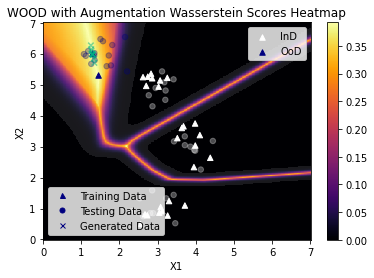

In [138]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_WOOD, G_GAN, "WOOD with Augmentation", ind_idx, ood_idx, m=350)

0.99: 0.9980000257492065
Rejection Threshold: 0.0001065497635863697
Rejection Region Proportion: 35.09%


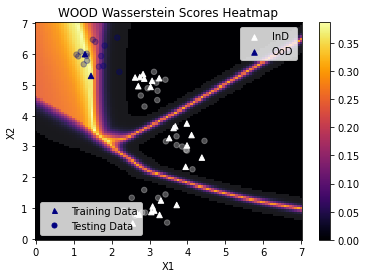

In [128]:
D_WOOD = DSIM(128).to(DEVICE)
D_WOOD.load_state_dict(torch.load(f"simulation_log/example/eg-[n=2]/ckpt/D_WOOD.pt"))
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_WOOD, None, "WOOD", ind_idx, ood_idx, m=100)

In [ ]:
# plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
# cbar = plt.colorbar(ticks=list(np.arange(0.05, 0.4, 0.05)) + [threshold], orientation='vertical')
# str_label = [f"{x:.2f}" for x in list(np.round(np.arange(0.05, 0.4, 0.05), 2))] + ['T']
# cbar.ax.set_yticklabels(str_label) 

#### Plot GAN

0.99: 0.9980000257492065
Rejection Threshold: 0.0009397082170471494
Rejection Region Proportion: 36.03%


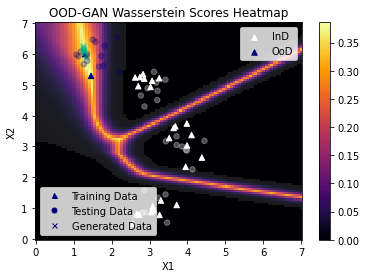

In [129]:
from simulation import plot_heatmap
D_GAN = DSIM(128).to(DEVICE)
D_GAN.load_state_dict(torch.load(f"simulation_log/example/eg-[n=2]/ckpt/D_GAN.pt"))
G_GAN = GSIM(128).to(DEVICE)
G_GAN.load_state_dict(torch.load(f"simulation_log/example/eg-[n=2]/ckpt/G_GAN.pt"))
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_GAN, G_GAN, "OOD-GAN", ind_idx, ood_idx, m=100)

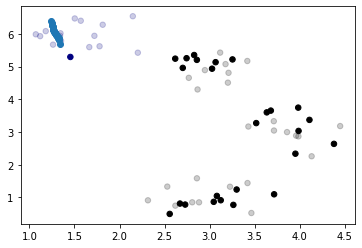

In [130]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='black', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Naive Augmentation on WOOD

In [89]:
from simulation import *
D_WOOD_AUG = DSIM(128).to(DEVICE)
# D_WOOD = DSIM_SINGLE()
# OOD data preparation
ood_bsz = 4
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
AUG_BATCH = list(np.array(OOD_BATCH)) + [(1, 1)]
print(AUG_BATCH)
AUG_BATCH = torch.tensor(AUG_BATCH)
print(AUG_BATCH.shape)
# Configuration
max_epoch = 256
lr = 1e-3
beta = 1
optimizer = torch.optim.Adam(D_WOOD_AUG.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD_AUG  = wood_training(D_WOOD_AUG , AUG_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

 28%|██▊       | 71/256 [00:39<01:47,  1.72it/s]

Epoch  # 71 | Tri loss: -0.3662                     | Tri accuracy: 1.0
tensor(0.3885, grad_fn=<WassersteinBackward>)
Epoch  # 71 | Val loss: 0.0075                     | Val accuracy: 1.0


 32%|███▏      | 81/256 [00:44<01:24,  2.06it/s]

Epoch  # 81 | Tri loss: -0.3808                     | Tri accuracy: 1.0
tensor(0.3808, grad_fn=<WassersteinBackward>)
Epoch  # 81 | Val loss: 0.0055                     | Val accuracy: 1.0


 36%|███▌      | 91/256 [00:49<01:18,  2.09it/s]

Epoch  # 91 | Tri loss: -0.3799                     | Tri accuracy: 1.0
tensor(0.3794, grad_fn=<WassersteinBackward>)
Epoch  # 91 | Val loss: 0.0044                     | Val accuracy: 1.0


 39%|███▉      | 101/256 [00:54<01:14,  2.09it/s]

Epoch  # 101 | Tri loss: -0.378                     | Tri accuracy: 1.0
tensor(0.3819, grad_fn=<WassersteinBackward>)
Epoch  # 101 | Val loss: 0.0037                     | Val accuracy: 1.0


 43%|████▎     | 111/256 [00:59<01:09,  2.09it/s]

Epoch  # 111 | Tri loss: -0.3806                     | Tri accuracy: 1.0
tensor(0.3860, grad_fn=<WassersteinBackward>)
Epoch  # 111 | Val loss: 0.0036                     | Val accuracy: 1.0


 47%|████▋     | 121/256 [01:03<01:03,  2.11it/s]

Epoch  # 121 | Tri loss: -0.3792                     | Tri accuracy: 1.0
tensor(0.3830, grad_fn=<WassersteinBackward>)
Epoch  # 121 | Val loss: 0.0028                     | Val accuracy: 1.0


 51%|█████     | 131/256 [01:08<00:59,  2.10it/s]

Epoch  # 131 | Tri loss: -0.3772                     | Tri accuracy: 1.0
tensor(0.3801, grad_fn=<WassersteinBackward>)
Epoch  # 131 | Val loss: 0.0032                     | Val accuracy: 1.0


 55%|█████▌    | 141/256 [01:13<00:54,  2.12it/s]

Epoch  # 141 | Tri loss: -0.3835                     | Tri accuracy: 1.0
tensor(0.3904, grad_fn=<WassersteinBackward>)
Epoch  # 141 | Val loss: 0.0022                     | Val accuracy: 1.0


 59%|█████▉    | 151/256 [01:17<00:50,  2.10it/s]

Epoch  # 151 | Tri loss: -0.3844                     | Tri accuracy: 1.0
tensor(0.3909, grad_fn=<WassersteinBackward>)
Epoch  # 151 | Val loss: 0.0022                     | Val accuracy: 1.0


 63%|██████▎   | 161/256 [01:22<00:44,  2.12it/s]

Epoch  # 161 | Tri loss: -0.3867                     | Tri accuracy: 1.0
tensor(0.3893, grad_fn=<WassersteinBackward>)
Epoch  # 161 | Val loss: 0.0018                     | Val accuracy: 1.0


 67%|██████▋   | 171/256 [01:27<00:40,  2.11it/s]

Epoch  # 171 | Tri loss: -0.3841                     | Tri accuracy: 1.0
tensor(0.3847, grad_fn=<WassersteinBackward>)
Epoch  # 171 | Val loss: 0.0019                     | Val accuracy: 1.0


 71%|███████   | 181/256 [01:32<00:35,  2.11it/s]

Epoch  # 181 | Tri loss: -0.3825                     | Tri accuracy: 1.0
tensor(0.3859, grad_fn=<WassersteinBackward>)
Epoch  # 181 | Val loss: 0.0018                     | Val accuracy: 1.0


 75%|███████▍  | 191/256 [01:36<00:30,  2.12it/s]

Epoch  # 191 | Tri loss: -0.3865                     | Tri accuracy: 1.0
tensor(0.3890, grad_fn=<WassersteinBackward>)
Epoch  # 191 | Val loss: 0.0016                     | Val accuracy: 1.0


 79%|███████▊  | 201/256 [01:41<00:26,  2.09it/s]

Epoch  # 201 | Tri loss: -0.3867                     | Tri accuracy: 1.0
tensor(0.3893, grad_fn=<WassersteinBackward>)
Epoch  # 201 | Val loss: 0.0013                     | Val accuracy: 1.0


 82%|████████▏ | 211/256 [01:46<00:21,  2.11it/s]

Epoch  # 211 | Tri loss: -0.3872                     | Tri accuracy: 1.0
tensor(0.3883, grad_fn=<WassersteinBackward>)
Epoch  # 211 | Val loss: 0.0013                     | Val accuracy: 1.0


 86%|████████▋ | 221/256 [01:51<00:16,  2.12it/s]

Epoch  # 221 | Tri loss: -0.3876                     | Tri accuracy: 1.0
tensor(0.3892, grad_fn=<WassersteinBackward>)
Epoch  # 221 | Val loss: 0.0012                     | Val accuracy: 1.0


 90%|████████▉ | 230/256 [01:55<00:13,  1.98it/s]

Epoch  # 231 | Tri loss: -0.3863                     | Tri accuracy: 1.0
tensor(0.3894, grad_fn=<WassersteinBackward>)


 90%|█████████ | 231/256 [01:56<00:15,  1.63it/s]

Epoch  # 231 | Val loss: 0.001                     | Val accuracy: 1.0


 94%|█████████▍| 241/256 [02:02<00:08,  1.77it/s]

Epoch  # 241 | Tri loss: -0.385                     | Tri accuracy: 1.0
tensor(0.3786, grad_fn=<WassersteinBackward>)
Epoch  # 241 | Val loss: 0.0012                     | Val accuracy: 1.0


 98%|█████████▊| 251/256 [02:07<00:02,  2.07it/s]

Epoch  # 251 | Tri loss: -0.3854                     | Tri accuracy: 1.0
tensor(0.3837, grad_fn=<WassersteinBackward>)
Epoch  # 251 | Val loss: 0.0009                     | Val accuracy: 1.0


100%|██████████| 256/256 [02:09<00:00,  1.98it/s]


0.99: 1.0
Rejection Threshold: 0.00028495890786870456
Rejection Region Proportion: 45.84%


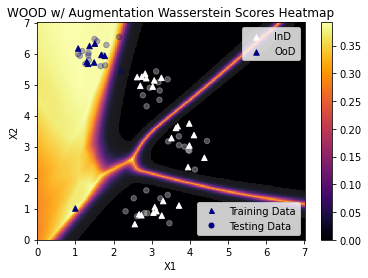

In [90]:
m = 400
fig, ax = plt.subplots()
with torch.no_grad():
    xi = np.linspace(0, 7, m, endpoint=True)
    yi = np.linspace(0, 7, m, endpoint=True)
    xy_pos = np.array(list(product(xi, yi)))
    zi = torch.softmax(D_WOOD_AUG(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
    # print(zi.shape)
    si = ood_wass_loss(zi)
    threshold = calculate_accuracy(D=D_WOOD_AUG, ind=IND_X, ood=OOD_X, tnr=0.99)
    mask = si > threshold
print(f"Rejection Threshold: {threshold}")
print(f"Rejection Region Proportion: {100 * sum(mask) / len(mask):.2f}%")   
# Plot
# Heatmap
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", marker='^',sizes=[30]*len(IND_X), alpha=1)
plt.scatter(AUG_BATCH[:,0], AUG_BATCH[:,1], c='navy', label="OoD",marker='^', sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.3)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.3)

plt.title(f"WOOD w/ Augmentation Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
# Legend Processing
leg = plt.legend()
ax.add_artist(leg)
markers = ['^', 'o']
legends = ['Training Data', 'Testing Data']
h = [plt.plot([],[], color="navy", marker=mk, ls="",ms=5)[0] for mk in markers]
plt.legend(handles=h, labels=legends, loc='lower right')
# Save plots
plt.savefig(f"simulation_log/plot/WOOD-AUG.jpg", dpi=1500)

### Distributional Shift

In [95]:
z_ind = torch.softmax(D_WOOD(torch.tensor(IND_X, dtype=torch.float32)), dim=-1)
s_ind = ood_wass_loss(z_ind)
# print(threshold)
z_ood = torch.softmax(D_WOOD(torch.tensor(OOD_X, dtype=torch.float32)), dim=-1)
s_ood = ood_wass_loss(z_ood)

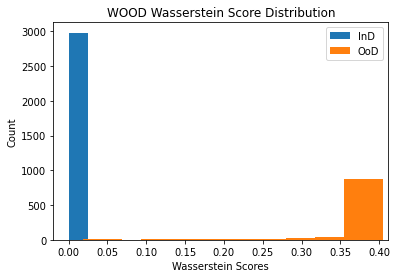

In [96]:
plt.hist(s_ind,width=0.025, label='InD')
plt.hist(s_ood,width=0.05, label='OoD')
plt.title("WOOD Wasserstein Score Distribution")
plt.xlabel("Wasserstein Scores")
plt.ylabel("Count")
plt.legend()
plt.savefig("../Notebooks/simulation_log/plot/WOOD-hist.jpg", dpi=1000)

#### GAN

In [97]:
z_ind = torch.softmax(D_GAN(torch.tensor(IND_X, dtype=torch.float32)), dim=-1)
s_ind = ood_wass_loss(z_ind)
z_ood = torch.softmax(D_GAN(torch.tensor(OOD_X, dtype=torch.float32)), dim=-1)
s_ood = ood_wass_loss(z_ood)

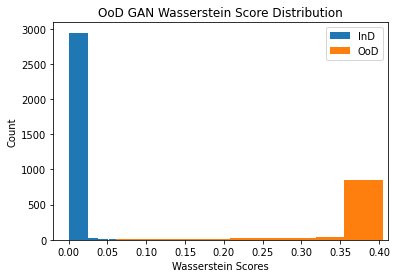

In [98]:
plt.hist(s_ind,width=0.025, label='InD')
plt.hist(s_ood,width=0.05, label='OoD')
plt.title("OoD GAN Wasserstein Score Distribution")
plt.xlabel("Wasserstein Scores")
plt.ylabel("Count")
plt.legend()
plt.savefig("../Notebooks/simulation_log/plot/OoD-GAN-hist.jpg", dpi=1000)

### Save

In [99]:
torch.save(D.state_dict(), "simulation_log/example/D.pt")
torch.save(D_WOOD.state_dict(), "simulation_log/example/D_WOOD.pt")
torch.save(D_WOOD_AUG.state_dict(), "simulation_log/example/D_WOOD_AUG.pt")
torch.save(D_GAN.state_dict(), "simulation_log/example/D_GAN.pt")
torch.save(G_GAN.state_dict(), "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')
torch.save((ind_idx, ood_idx), 'simulation_log/example/plot_idx.pt')